Notes:
- doesn't work even without transit
- try changing priors

Found bug! Independent variable = time for all submodels!!!

In [37]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

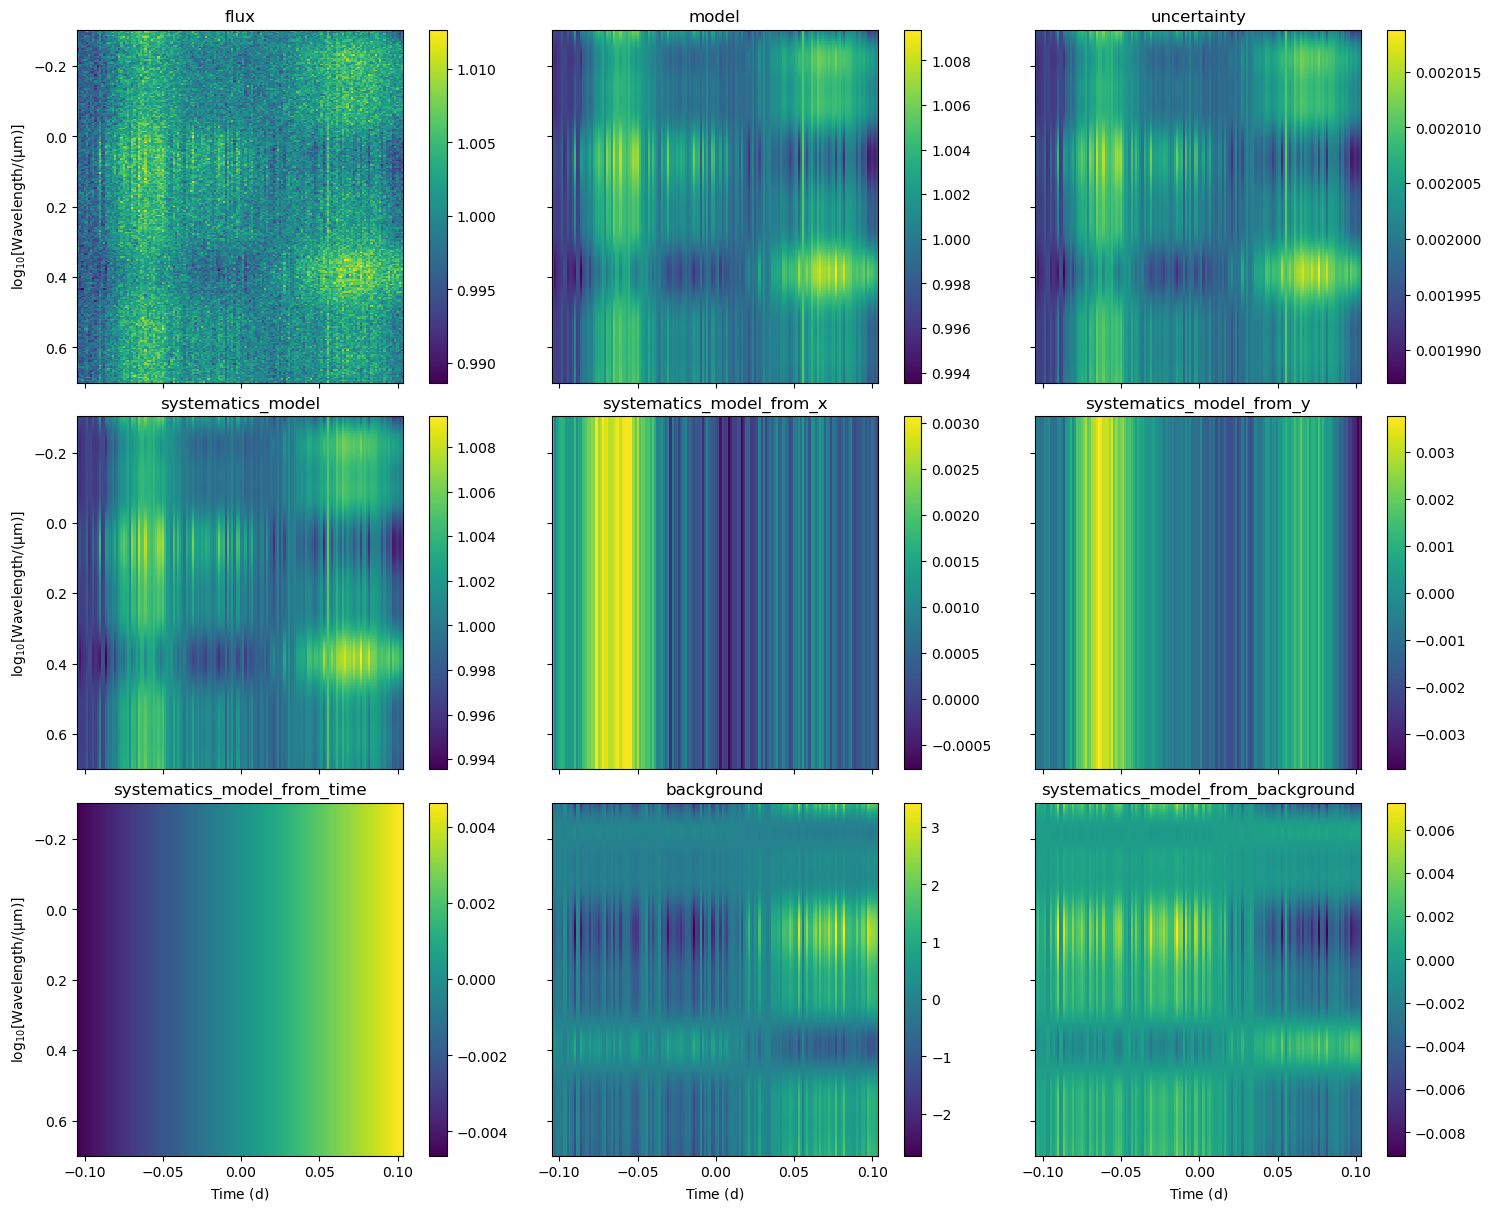

In [38]:
s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [51]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1)
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x")
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y")
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background")
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.001),
)

Setup Polynomial dep on: time
Setup Polynomial dep on: x
Setup Polynomial dep on: y
Setup Polynomial dep on: background


In [52]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'time':b,'x':b_x,'y':b_y,'background':b_bkg}) #'transit':t,
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

time
{'required_parameters': ['p_0'], 'degree': 1, 'independant_variable': 'time'}
Setup Polynomial dep on: time
x
{'required_parameters': ['p_0'], 'degree': 1, 'independant_variable': 'x'}
Setup Polynomial dep on: x
y
{'required_parameters': ['p_0'], 'degree': 1, 'independant_variable': 'y'}
Setup Polynomial dep on: y
background
{'required_parameters': ['p_0'], 'degree': 1, 'independant_variable': 'background'}
Setup Polynomial dep on: background
{'time': <experimental chromatic polynomial model 🌈>, 'x': <experimental chromatic polynomial model 🌈>, 'y': <experimental chromatic polynomial model 🌈>, 'background': <experimental chromatic polynomial model 🌈>}
         time_p_1 ~ Normal
            x_p_1 ~ Normal
            y_p_1 ~ Normal
   background_p_1 ~ Normal
wavelength_0_data ~ Normal
wavelength_1_data ~ Normal
wavelength_2_data ~ Normal
wavelength_3_data ~ Normal
wavelength_4_data ~ Normal


In [53]:
cm.chromatic_models['x'].independant_variable,cm.chromatic_models['y'].independant_variable

('x', 'y')

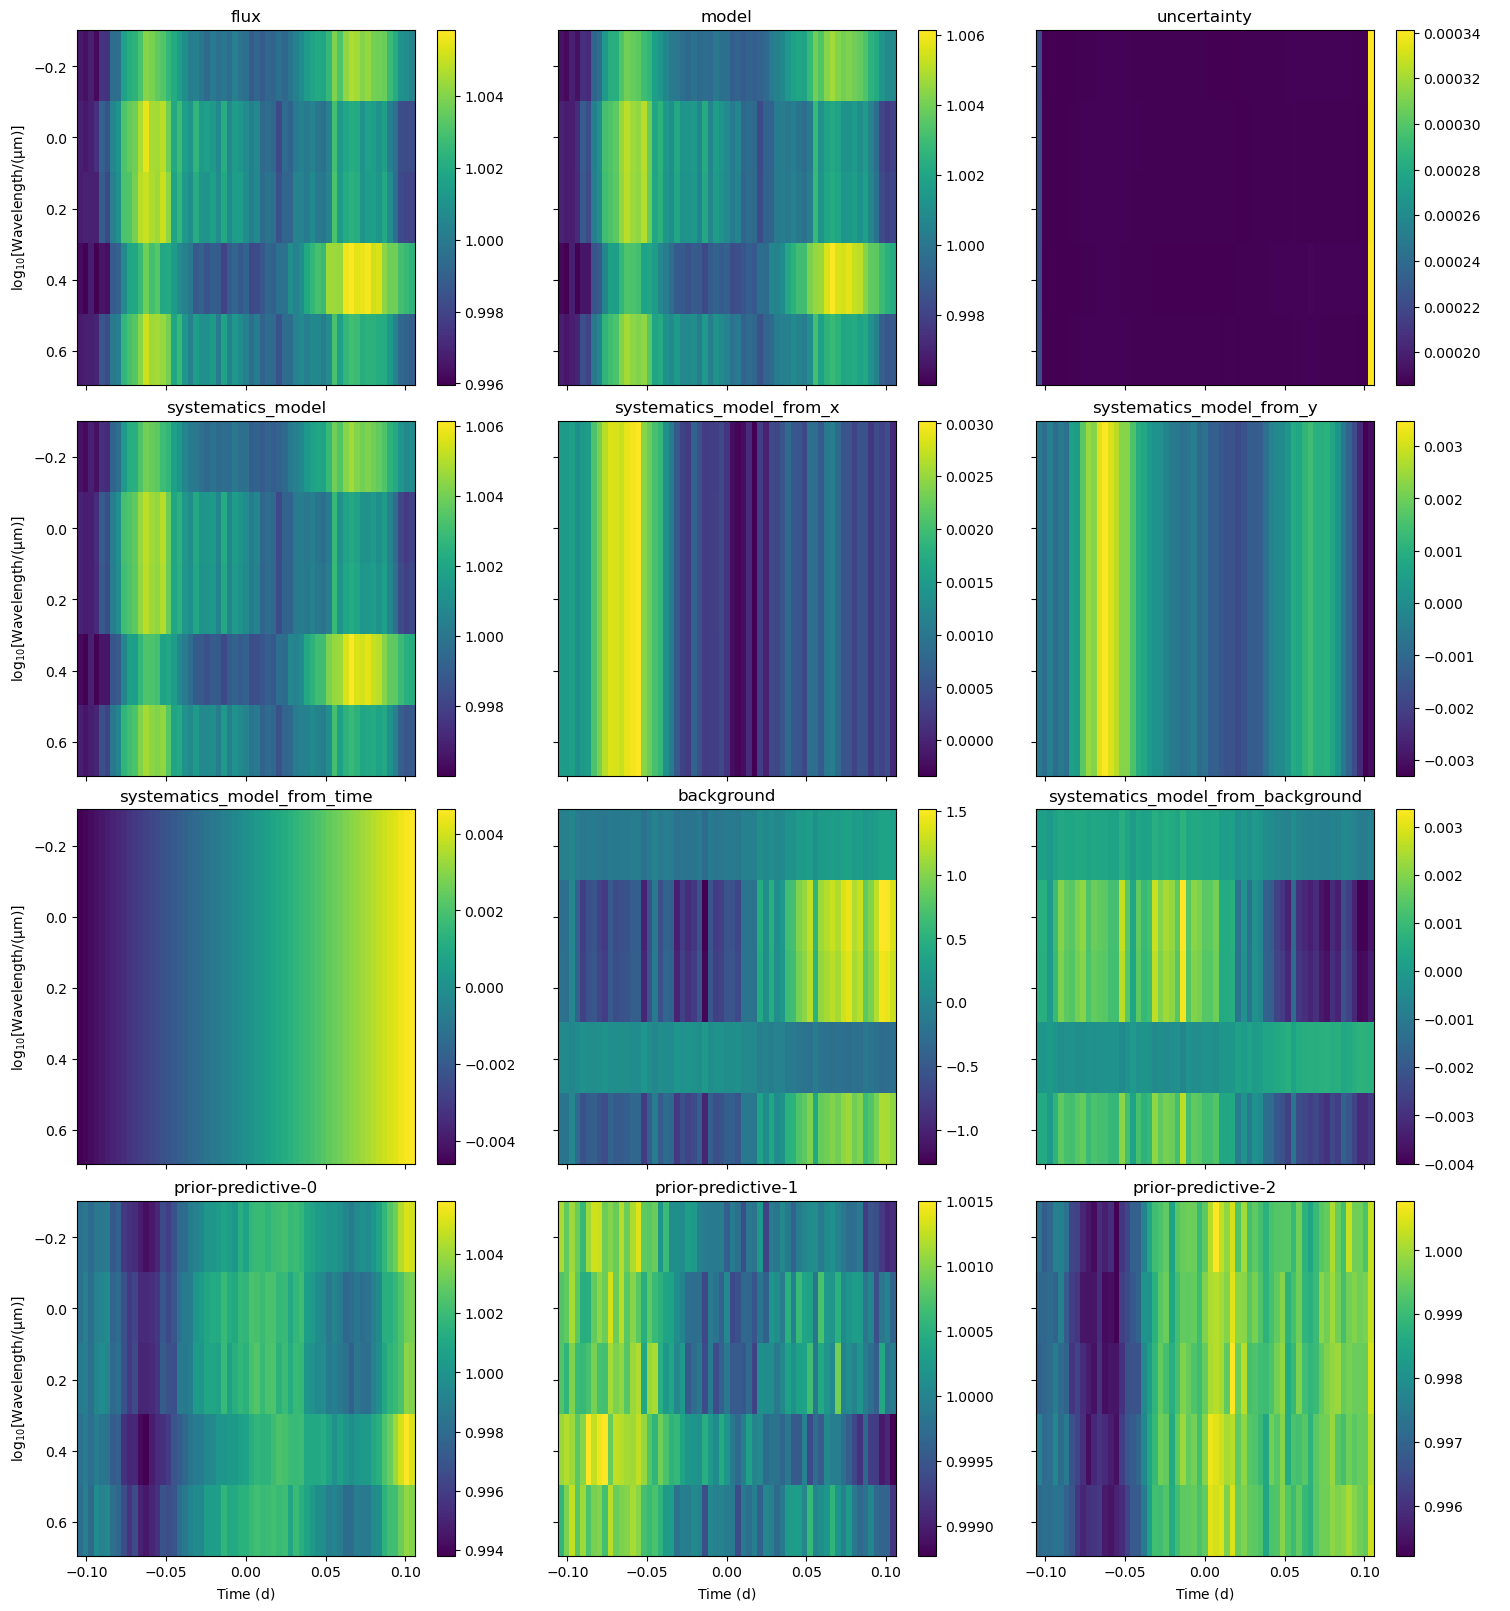

In [54]:
cm.plot_priors()

In [55]:
opt = cm.optimize()
cm.sample(start=opt, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [background_p_1, y_p_1, x_p_1, time_p_1]


message: Optimization terminated successfully.
logp: -22245.331208245745 -> 2214.6284422288754



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [background_p_1, y_p_1, x_p_1, time_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


                    mean        sd    hdi_3%   hdi_97%     mcse_mean  \
time_p_1        0.045021  0.000270  0.044515  0.045517  4.300000e-06   
x_p_1           0.001340  0.000013  0.001317  0.001366  2.000000e-07   
y_p_1           0.001761  0.000016  0.001729  0.001789  2.000000e-07   
background_p_1 -0.002642  0.000024 -0.002688 -0.002598  4.000000e-07   

                     mcse_sd     ess_bulk     ess_tail     r_hat  
time_p_1        3.000000e-06  3962.810766  2971.550818  0.999822  
x_p_1           1.000000e-07  4073.222970  3019.363598  1.000436  
y_p_1           2.000000e-07  4112.652606  2879.779082  0.999777  
background_p_1  3.000000e-07  3777.376901  2859.257091  1.000524  



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

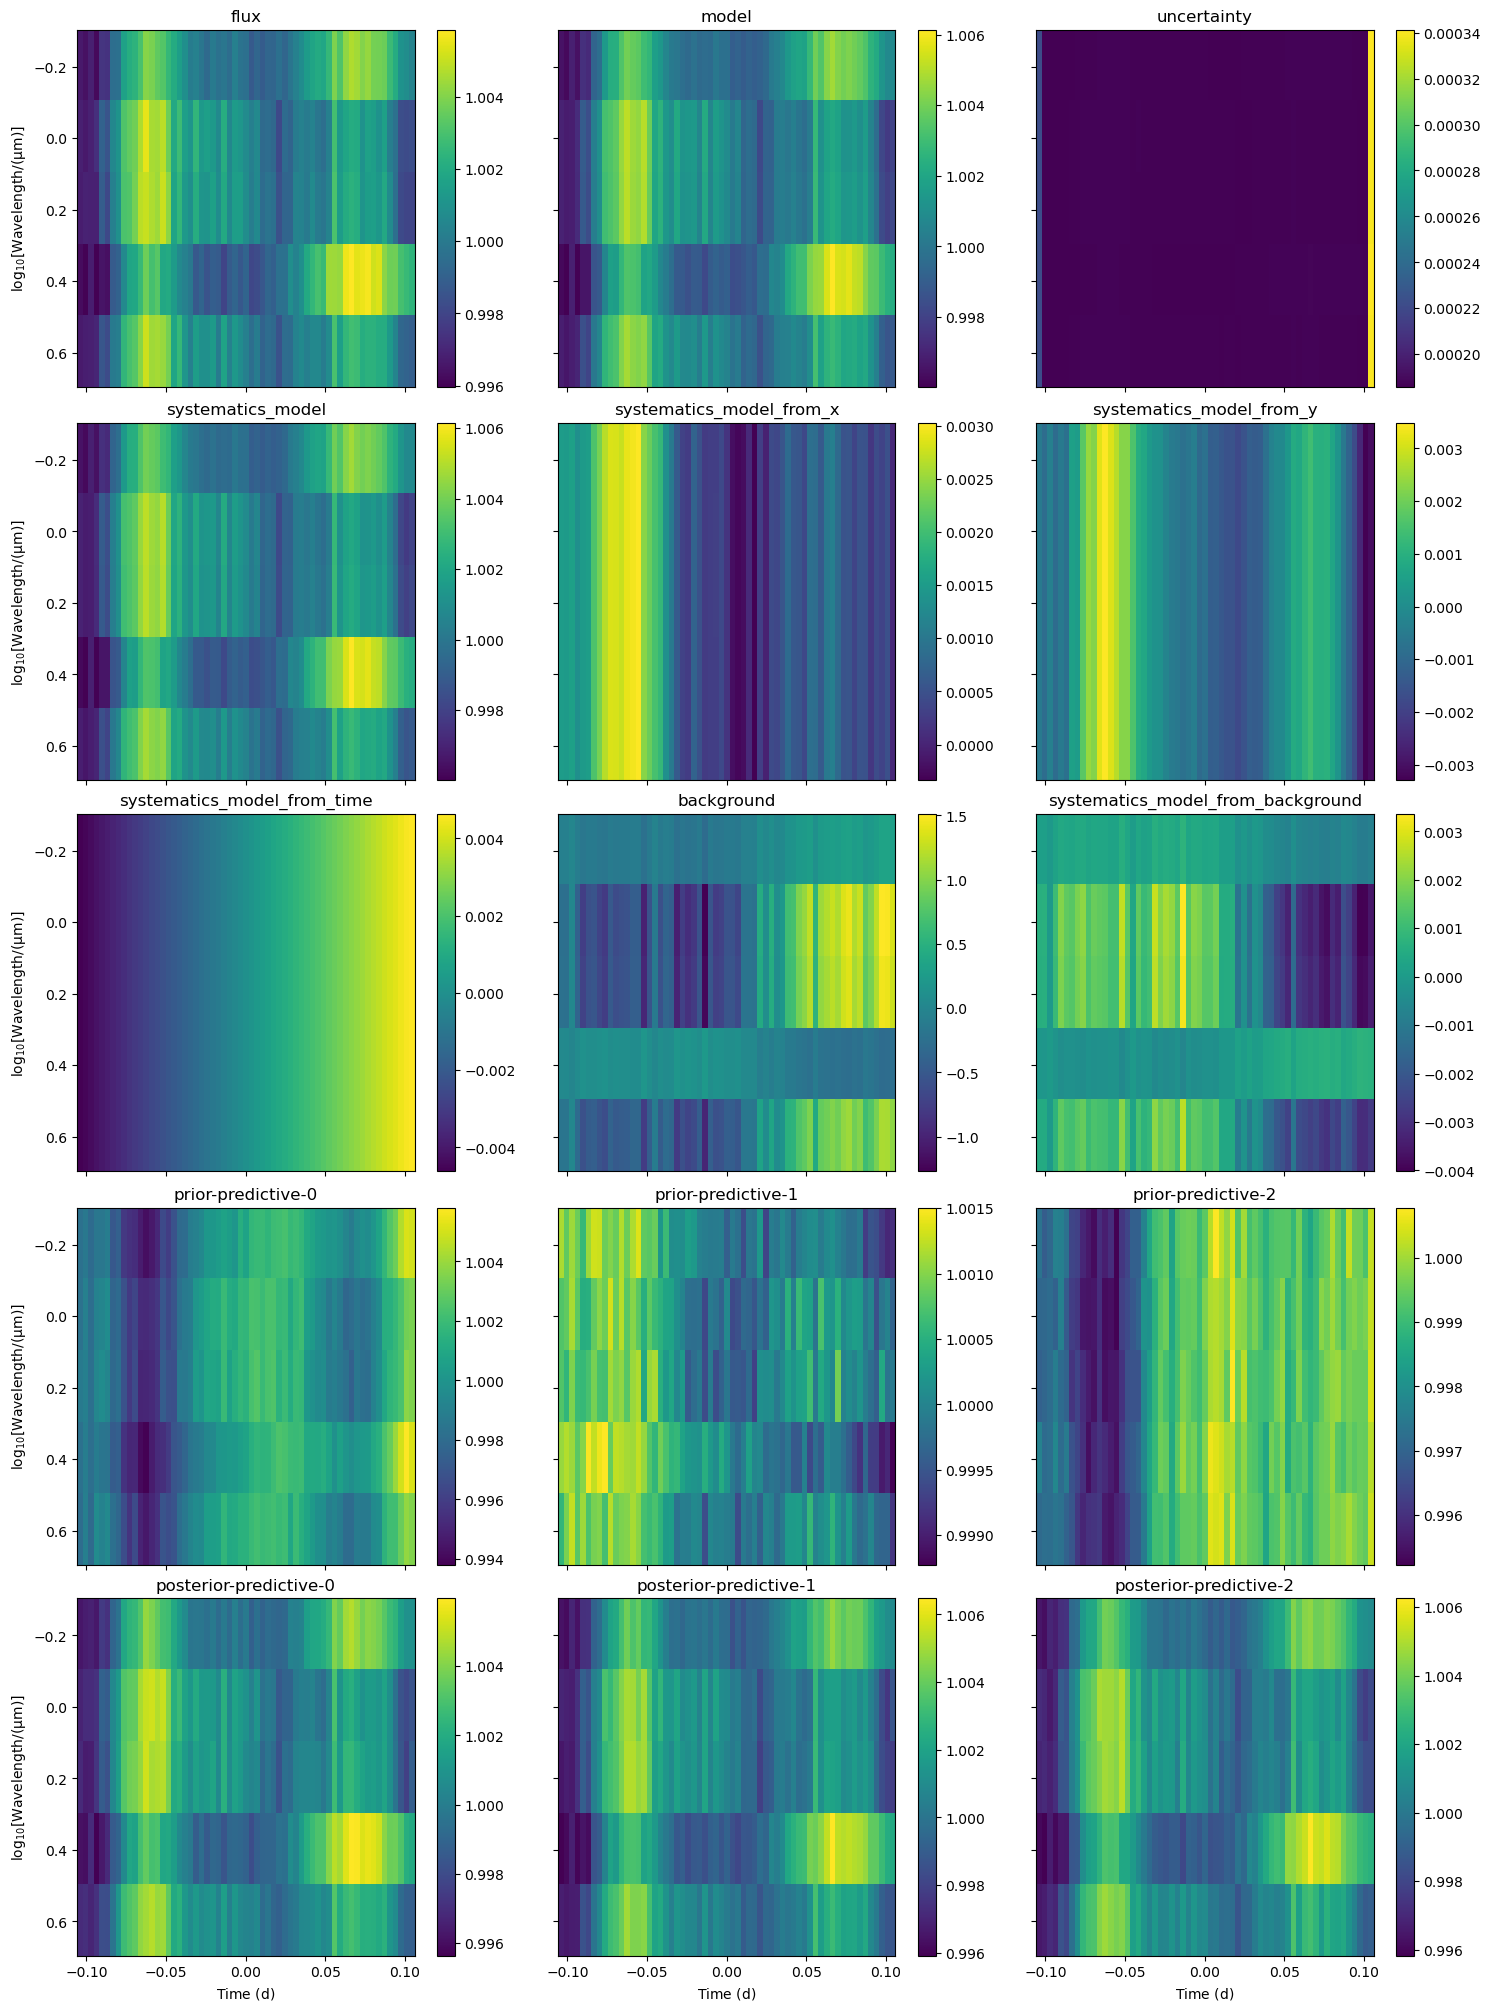

In [56]:
cm.plot_posteriors()

In [57]:
cm.summary['mean']

time_p_1          0.045021
x_p_1             0.001340
y_p_1             0.001761
background_p_1   -0.002642
Name: mean, dtype: float64

In [58]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.001302784077468495
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.0017690445319806084
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = 0.002695076044832677
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.0026526629569606063
   offset_background = 0
    sigma_background = 1


Got error No model on context stack. trying to find log_likelihood in translation.

🌈 Warning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'time_p_1'}>,
        <AxesSubplot:title={'center':'time_p_1'}>],
       [<AxesSubplot:title={'center':'x_p_1'}>,
        <AxesSubplot:title={'center':'x_p_1'}>],
       [<AxesSubplot:title={'center':'y_p_1'}>,
        <AxesSubplot:title={'center':'y_p_1'}>],
       [<AxesSubplot:title={'center':'background_p_1'}>,
        <AxesSubplot:title={'center':'background_p_1'}>]], dtype=object)

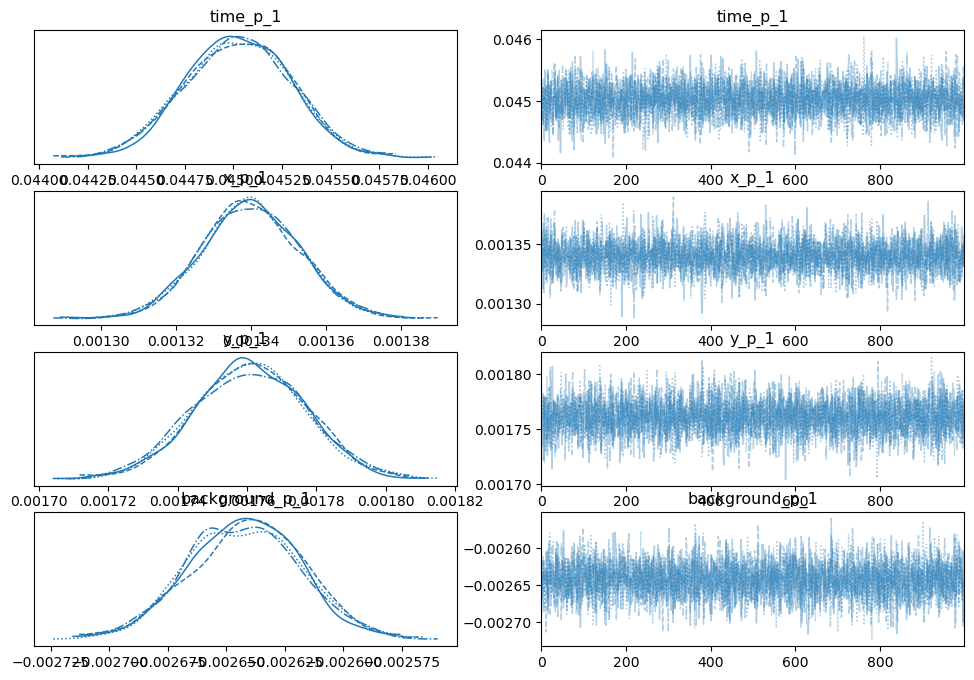

In [59]:
az.plot_trace(cm.trace)

In [60]:
systematics_model = 1 + \
        (s.metadata['systematics_components']['c_x'] * s.x) + \
        (s.metadata['systematics_components']['c_y'] * s.y) + \
        (s.metadata['systematics_components']['c_time'] * (s.time.to_value("day")+0.00069444)/0.06013932) + \
        (s.metadata['systematics_components']['c_background'] * s.background) 

In [61]:
cm.data.fluxlike['test_residuals-0'] = cm.data.fluxlike['posterior-predictive-0'] - systematics_model

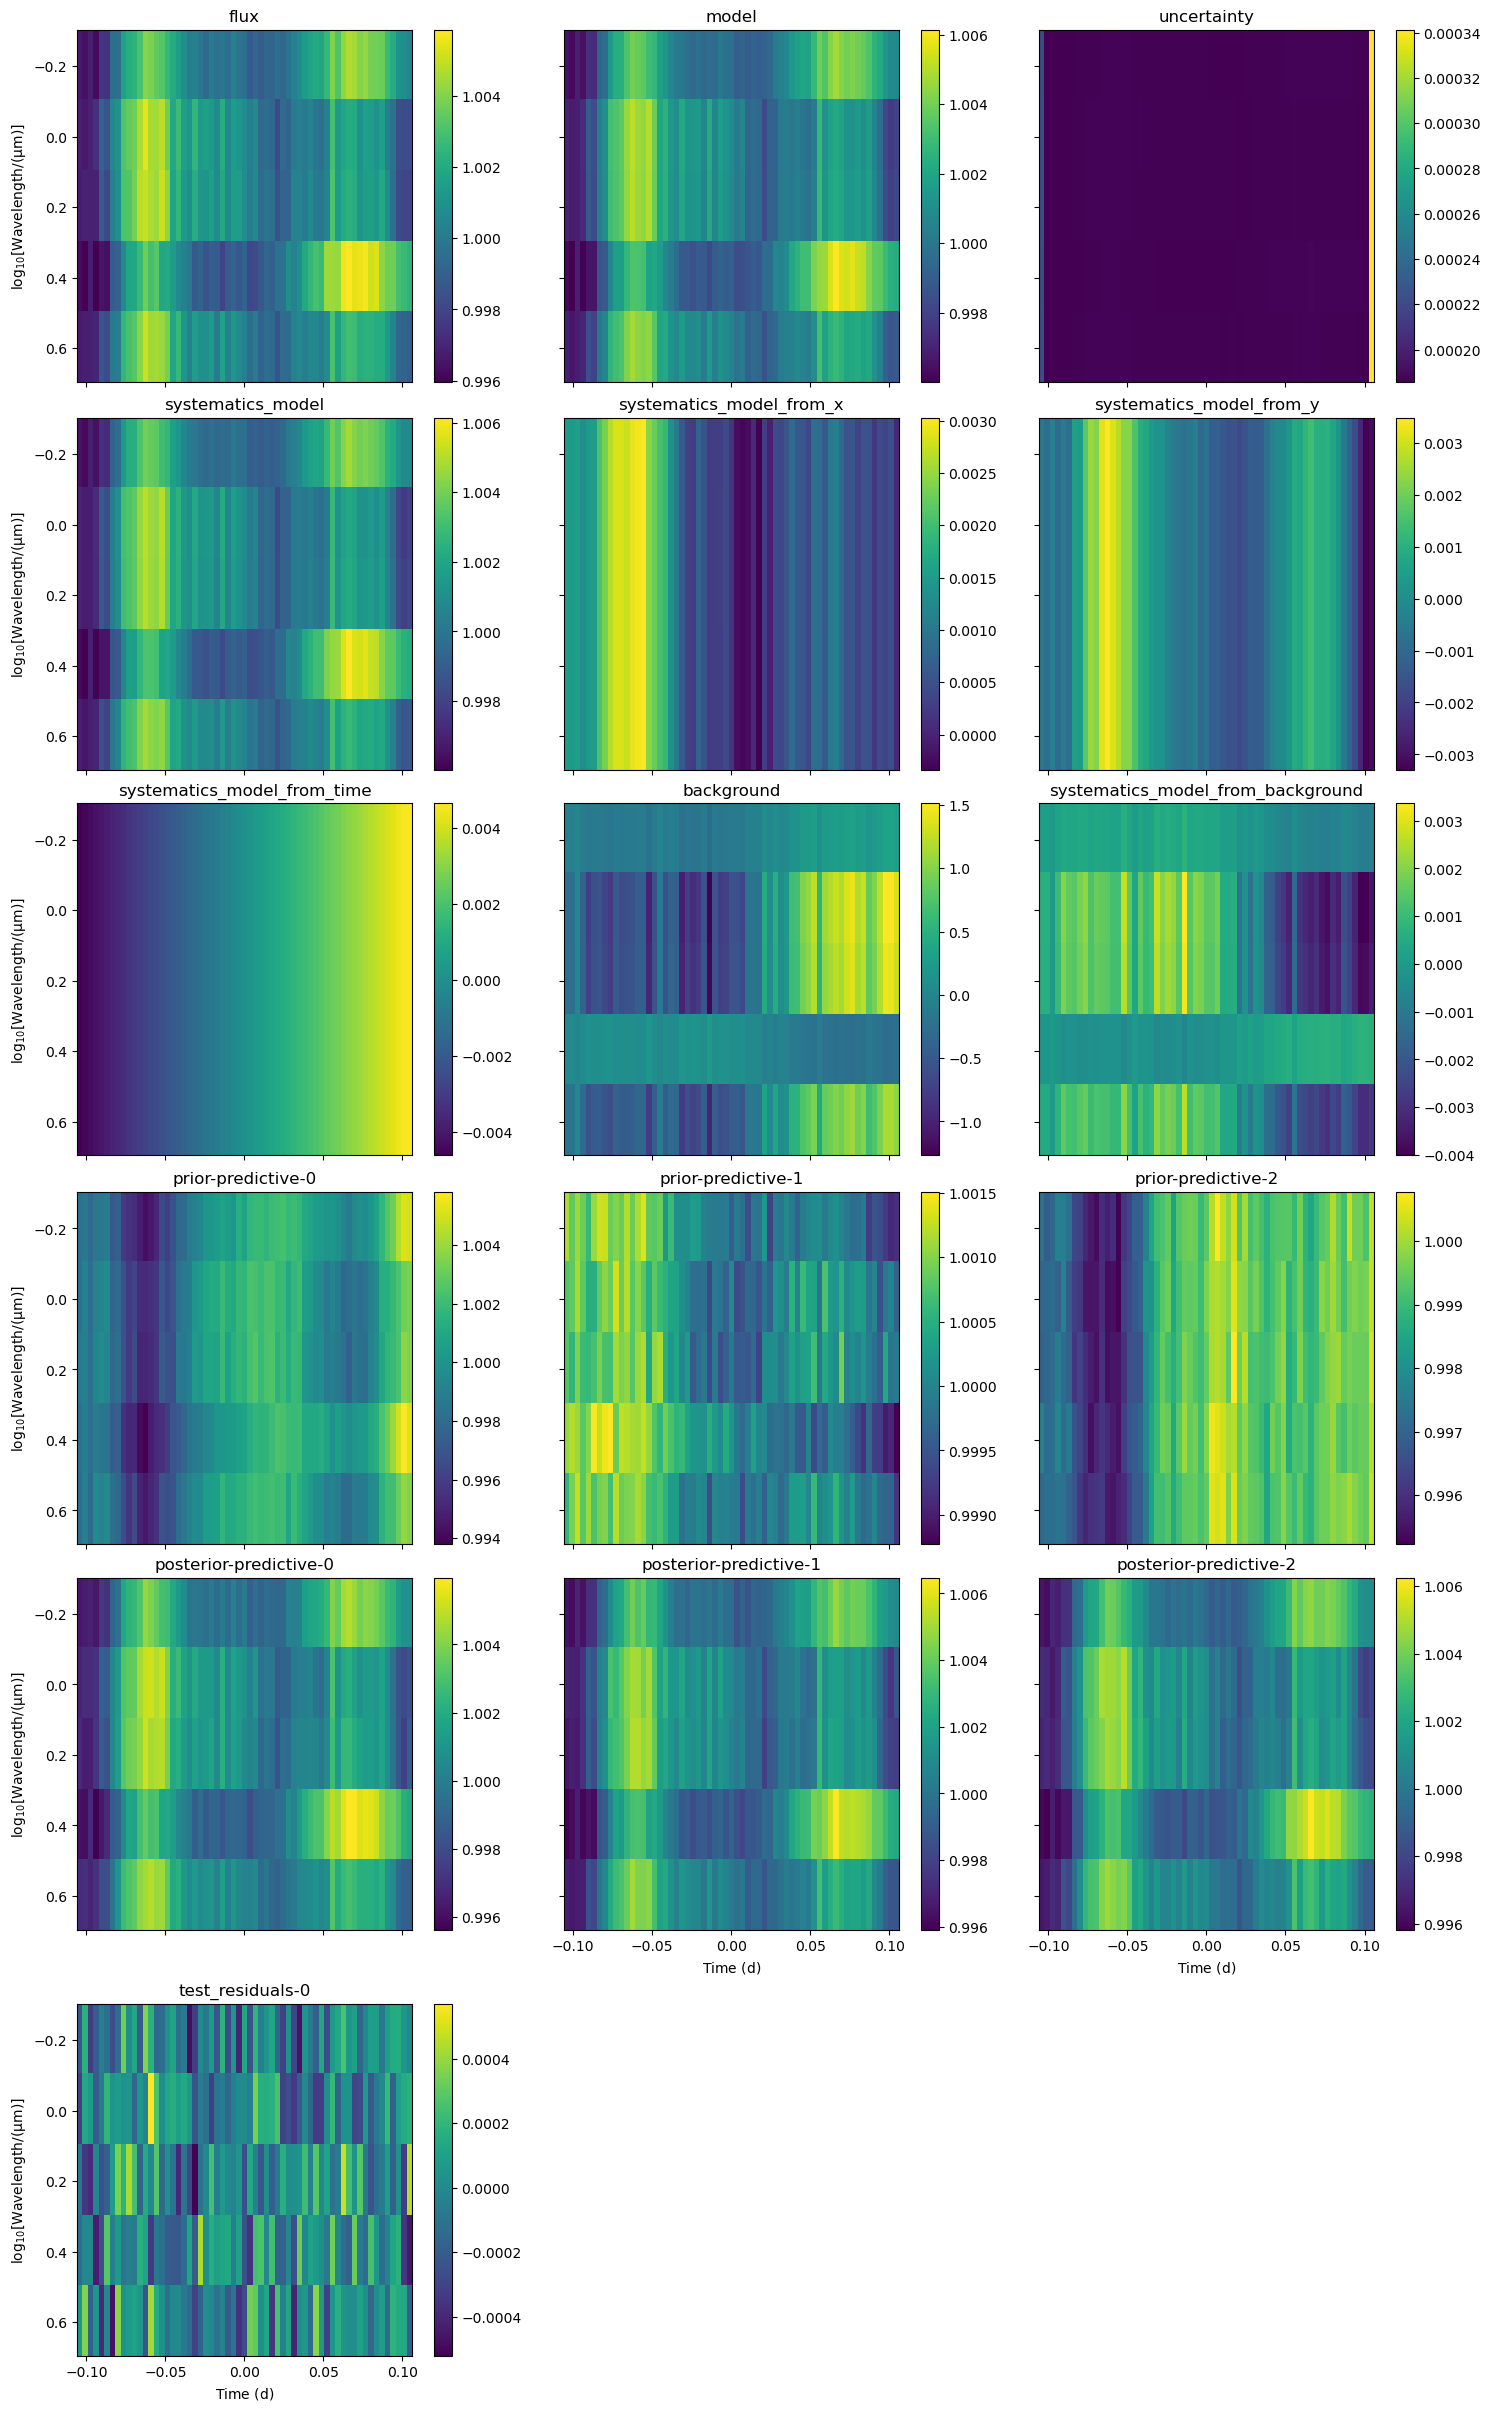

In [62]:
cm.data.imshow_quantities()